In [264]:
## pip install lightgbm

In [265]:
## pip install catboost

In [266]:
## pip install ipywidgets

In [267]:
# pip install xgboost

In [268]:
import numpy as np
import pandas as pd
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
import sklearn
from sklearn.model_selection import KFold
import IPython
from IPython.display import clear_output
import copy
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import xgboost
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [269]:
# import datasets
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')
building = pd.read_csv('../dataset/building_info.csv')

In [270]:
display(train)
display(test)

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
203995,100_20220824 19,100,20220824 19,23.1,NaN,0.9,86.0,0.5,NaN,881.04
203996,100_20220824 20,100,20220824 20,22.4,NaN,1.3,86.0,0.0,NaN,798.96
203997,100_20220824 21,100,20220824 21,21.3,NaN,1.0,92.0,NaN,NaN,825.12
203998,100_20220824 22,100,20220824 22,21.0,NaN,0.3,94.0,NaN,NaN,640.08


,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [271]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(C)          204000 non-null  float64
 4   강수량(mm)        43931 non-null   float64
 5   풍속(m/s)        203981 non-null  float64
 6   습도(%)          203991 non-null  float64
 7   일조(hr)         128818 non-null  float64
 8   일사(MJ/m2)      116087 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB


In [272]:
train_df = train.copy()

train_df = train_df.drop(columns =  ['num_date_time', '일조(hr)', '일사(MJ/m2)', '강수량(mm)'])
train_df = train_df.rename(columns = {'기온(C)':'기온', '습도(%)':'습도', '풍속(m/s)':'풍속', '전력소비량(kWh)':'전력소비량'})

In [273]:
# 결측치 처리
def fill_missing_with_avg(df, columns):
    for i in range(len(df)):
        if pd.isna(df.loc[i, columns]):
            prev_value = df.loc[i-1, columns]
            next_value = df.loc[i+1, columns]
            avg_value = (prev_value + next_value) / 2
            if pd.isna(prev_value) or pd.isna(next_value):
                building_num = df.loc[i,:]['건물번호']
                date = df.loc[i,:]['일시'][:8]
                avg_value = df[(df['건물번호'] == building_num) & (df['일시'].str.contains(date))][columns].mean()

            df.loc[i, columns] = avg_value

fill_missing_with_avg(train_df, '습도')

In [274]:
## 일시 columns
train_df['일시'] = pd.to_datetime(train_df['일시'])
train_df['월'] = train_df['일시'].dt.month
train_df['일'] = train_df['일시'].dt.day
train_df['요일'] = train_df['일시'].dt.weekday
train_df['시간'] = train_df['일시'].dt.hour
train_df['날짜'] = train_df['일시'].dt.date

train_df['sin_요일'] = np.sin(2*np.pi*(train_df['요일'])/6)
train_df['cos_요일'] = np.cos(2*np.pi*(train_df['요일'])/6)
train_df['sin_시간'] = np.sin(2*np.pi*(train_df['시간'])/23)
train_df['cos_시간'] = np.cos(2*np.pi*(train_df['시간'])/23)
# train_df['sin_일'] = np.sin(2*np.pi*(train_df['일']-1)/30)
# train_df['cos_일'] = np.cos(2*np.pi*(train_df['일']-1)/30)
# train_df['일수'] = train_df['일시'].dt.dayofyear

train_df['휴일'] = train_df['요일'].isin([5,6]).astype(int)
train_df.loc[(train_df['월'] == 6) & (train_df['일'] == 6), '휴일'] = 1
train_df.loc[(train_df['월'] == 8) & (train_df['일'] == 15), '휴일'] = 1

cat_month = pd.get_dummies(train_df['월'])
train_df = pd.concat([train_df, cat_month], axis = 1).drop(columns = ['월'])

In [275]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   건물번호    204000 non-null  int64         
 1   일시      204000 non-null  datetime64[ns]
 2   기온      204000 non-null  float64       
 3   풍속      203981 non-null  float64       
 4   습도      204000 non-null  float64       
 5   전력소비량   204000 non-null  float64       
 6   일       204000 non-null  int64         
 7   요일      204000 non-null  int64         
 8   시간      204000 non-null  int64         
 9   날짜      204000 non-null  object        
 10  sin_요일  204000 non-null  float64       
 11  cos_요일  204000 non-null  float64       
 12  sin_시간  204000 non-null  float64       
 13  cos_시간  204000 non-null  float64       
 14  휴일      204000 non-null  int32         
 15  6       204000 non-null  uint8         
 16  7       204000 non-null  uint8         
 17  8       204000 non-null  uint

In [276]:
# train_df.set_index(train_df['일시'], inplace = True)
# train_df

In [277]:
# train_df['풍속'] = train_df['풍속'].interpolate(method = 'time')

In [278]:
# train_df['습도'] = train_df['습도'].interpolate(method = 'time')

In [279]:
# train_df['강수량'] = train_df['강수량'].interpolate(method = 'time')

In [280]:
# train_df = train_df.fillna(0)

In [281]:
# train_df.reset_index(drop = True, inplace = True)

In [282]:
# 건물별, 요일별, 시간별 발전량 평균 넣어주기
weekday_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['요일별_평균'] = train_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:45<00:00, 1935.10it/s]


In [283]:
# 건물별 시간, 요일별 발전량 표준편차 넣어주기
# weekday_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간', '요일'], aggfunc = np.std).reset_index()
# tqdm.pandas()
# train_df['요일별_표준편차'] = train_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)

In [284]:
# 건물별 시간별 발전량 평균 넣어주기
hour_mean = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.mean).reset_index()
tqdm.pandas()
train_df['시간별_평균'] = train_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:07<00:00, 3037.62it/s]


In [285]:
# 건물별 시간별 발전량 표준편차 넣어주기
hour_std = pd.pivot_table(train_df, values = '전력소비량', index = ['건물번호', '시간'], aggfunc = np.std).reset_index()
tqdm.pandas()
train_df['시간별_표준편차'] = train_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

100%|██████████| 204000/204000 [01:03<00:00, 3201.99it/s]


In [286]:
# 파생변수 생성 - 열지수
train_df['기온(F)'] = (train_df['기온'] * 9/5) + 32
T = train_df['기온(F)']
RH = train_df['습도']
train_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
# train_df['열지수'] = pd.cut(train_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])


(array([ 4423., 14707., 33221., 52404., 41295., 31996., 17516.,  7126.,
         1155.,   157.]),
 array([ 55.63234398,  61.99087681,  68.34940963,  74.70794245,
         81.06647528,  87.4250081 ,  93.78354092, 100.14207375,
        106.50060657, 112.8591394 , 119.21767222]),
 <BarContainer object of 10 artists>)

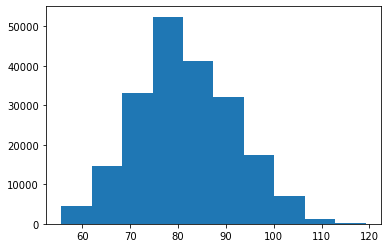

In [287]:
plt.hist(train_df['열지수'])

In [288]:
# 파생변수 생성 - 체감온도
# T = train_df['기온']
# W = train_df['풍속']
# train_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

In [289]:
# plt.hist(train_df['체감온도'])

In [290]:
# 파생변수 생성 - 불쾌지수
T = 9/5*train_df['기온']
RH = train_df['습도']
train_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
train_df['불쾌지수'] = pd.cut(train_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])
discomfort = pd.get_dummies(train_df['불쾌지수'])
train_df = pd.concat([train_df, discomfort], axis = 1).rename(columns = {0:'불쾌지수_0', 1:'불쾌지수_1', 2:'불쾌지수_2', 3:'불쾌지수_3'}).drop(columns = ['불쾌지수'])

In [291]:
train_df

,건물번호,일시,기온,풍속,습도,전력소비량,일,요일,시간,날짜,...,8,요일별_평균,시간별_평균,시간별_표준편차,기온(F),열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,불쾌지수_3
0,1,2022-06-01 00:00:00,18.6,0.9,42.0,1085.28,1,2,0,2022-06-01,...,0,1774.744615,1706.318118,446.882767,65.48,78.408916,1,0,0,0
1,1,2022-06-01 01:00:00,18.0,1.1,45.0,1047.36,1,2,1,2022-06-01,...,0,1687.347692,1622.620235,439.662704,64.40,79.147251,1,0,0,0
2,1,2022-06-01 02:00:00,17.7,1.5,45.0,974.88,1,2,2,2022-06-01,...,0,1571.483077,1506.971294,412.071906,63.86,79.492837,1,0,0,0
3,1,2022-06-01 03:00:00,16.7,1.4,48.0,953.76,1,2,3,2022-06-01,...,0,1522.153846,1437.365647,391.205981,62.06,80.948219,1,0,0,0
4,1,2022-06-01 04:00:00,18.4,2.8,43.0,986.40,1,2,4,2022-06-01,...,0,1506.793846,1447.321412,381.099697,65.12,78.649811,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,23.1,0.9,86.0,881.04,24,2,19,2022-08-24,...,1,964.873846,1010.462118,161.399578,73.58,72.567800,0,1,0,0
203996,100,2022-08-24 20:00:00,22.4,1.3,86.0,798.96,24,2,20,2022-08-24,...,1,882.184615,928.125176,137.566008,72.32,70.929804,0,1,0,0
203997,100,2022-08-24 21:00:00,21.3,1.0,92.0,825.12,24,2,21,2022-08-24,...,1,779.095385,830.032941,128.300189,70.34,66.382661,0,1,0,0
203998,100,2022-08-24 22:00:00,21.0,0.3,94.0,640.08,24,2,22,2022-08-24,...,1,663.267692,723.100235,112.464079,69.80,64.810657,0,1,0,0


In [292]:
# 파생변수 생성 - CDH
def CDH(x):
    y = []
    for i in range(len(x)):
        if i<11:
            y.append(np.sum(x[:(i+1)]-26))
        else:
            y.append(np.sum(x[(i-11):(i+1)]-26))
    return np.array(x)

In [293]:
cdhs = np.array([])

for num in range(1, 101):
    temp = train_df[train_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

train_df['CDH'] = cdhs

(array([  113.,  1349.,  8264., 12984., 31299., 62308., 51474., 27437.,
         8151.,   621.]),
 array([10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. , 31.7, 34.4, 37.1]),
 <BarContainer object of 10 artists>)

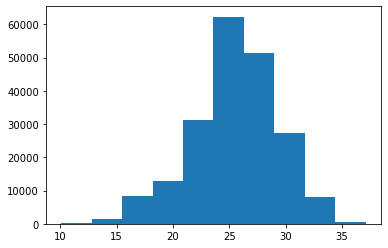

In [294]:
plt.hist(train_df['CDH'])

In [295]:
# 이상치 제거 -> 안하는게 나음
def detect_outliers(df,ratio): 
    outlier_indices = [] 
    Q1 = np.percentile(df, 25) 
    Q3 = np.percentile(df, 75) 
    IQR = Q3 - Q1 
    outlier_step = ratio * IQR 
    return ~(df < Q1 - outlier_step) | (df > Q3 + outlier_step)

# for i in range(100):    
#     idx = detect_outliers(train_target[i],1.25)
#     train_target[i] = train_target[i][idx]
#     train_input[i] = train_input[i][idx]


In [296]:
train_df.columns

Index([    '건물번호',       '일시',       '기온',       '풍속',       '습도',    '전력소비량',
              '일',       '요일',       '시간',       '날짜',   'sin_요일',   'cos_요일',
         'sin_시간',   'cos_시간',       '휴일',          6,          7,          8,
         '요일별_평균',   '시간별_평균', '시간별_표준편차',    '기온(F)',      '열지수',   '불쾌지수_0',
         '불쾌지수_1',   '불쾌지수_2',   '불쾌지수_3',      'CDH'],
      dtype='object')

In [297]:
train_df = train_df.drop(columns = ['일시', '일', '날짜', '기온(F)'])

In [298]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(12,2)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(train_df.columns[1:]):
#     ax = plt.subplot(grid[idx])
#     plt.hist(train_df[feature])
#     plt.title(f"{feature}")

In [299]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(7,1)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(['풍속', '습도', '전력소비량', '시간별_평균', '시간별_표준편차']):
#     ax = plt.subplot(grid[idx])
#     plt.hist(train_df[feature])
#     plt.title(f"{feature}")

In [300]:
# train_df['log_풍속'] = np.log1p(train_df['풍속'])
# train_df['log_전력소비량'] = np.log1p(train_df['전력소비량'])

# train_df['log_요일별_평균'] = np.log1p(train_df['요일별_평균'])
# train_df['log_요일별_표준편차'] = np.log1p(train_df['요일별_표준편차'])
# train_df['log_시간별_평균'] = np.log1p(train_df['시간별_평균'])
# train_df['log_시간별_표준편차'] = np.log1p(train_df['시간별_표준편차'])

In [301]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(6,1)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(['log_풍속', 'log_전력소비량', 'log_시간별_평균', 'log_시간별_표준편차']):
#     ax = plt.subplot(grid[idx])
#     plt.hist(train_df[feature])
#     plt.title(f"{feature}")

In [302]:
train_df

,건물번호,기온,풍속,습도,전력소비량,요일,시간,sin_요일,cos_요일,sin_시간,...,8,요일별_평균,시간별_평균,시간별_표준편차,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,불쾌지수_3,CDH
0,1,18.6,0.9,42.0,1085.28,2,0,0.866025,-0.5,0.000000e+00,...,0,1774.744615,1706.318118,446.882767,78.408916,1,0,0,0,18.6
1,1,18.0,1.1,45.0,1047.36,2,1,0.866025,-0.5,2.697968e-01,...,0,1687.347692,1622.620235,439.662704,79.147251,1,0,0,0,18.0
2,1,17.7,1.5,45.0,974.88,2,2,0.866025,-0.5,5.195840e-01,...,0,1571.483077,1506.971294,412.071906,79.492837,1,0,0,0,17.7
3,1,16.7,1.4,48.0,953.76,2,3,0.866025,-0.5,7.308360e-01,...,0,1522.153846,1437.365647,391.205981,80.948219,1,0,0,0,16.7
4,1,18.4,2.8,43.0,986.40,2,4,0.866025,-0.5,8.878852e-01,...,0,1506.793846,1447.321412,381.099697,78.649811,1,0,0,0,18.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,23.1,0.9,86.0,881.04,2,19,0.866025,-0.5,-8.878852e-01,...,1,964.873846,1010.462118,161.399578,72.567800,0,1,0,0,23.1
203996,100,22.4,1.3,86.0,798.96,2,20,0.866025,-0.5,-7.308360e-01,...,1,882.184615,928.125176,137.566008,70.929804,0,1,0,0,22.4
203997,100,21.3,1.0,92.0,825.12,2,21,0.866025,-0.5,-5.195840e-01,...,1,779.095385,830.032941,128.300189,66.382661,0,1,0,0,21.3
203998,100,21.0,0.3,94.0,640.08,2,22,0.866025,-0.5,-2.697968e-01,...,1,663.267692,723.100235,112.464079,64.810657,0,1,0,0,21.0


In [303]:
# plt.plot(train_df[['log_전력소비량']])
# # plt.plot(train_df[['log_요일별_평균']])
# plt.plot(train_df[['log_시간별_평균']])

In [304]:
train_df.columns

Index([    '건물번호',       '기온',       '풍속',       '습도',    '전력소비량',       '요일',
             '시간',   'sin_요일',   'cos_요일',   'sin_시간',   'cos_시간',       '휴일',
                6,          7,          8,   '요일별_평균',   '시간별_평균', '시간별_표준편차',
            '열지수',   '불쾌지수_0',   '불쾌지수_1',   '불쾌지수_2',   '불쾌지수_3',      'CDH'],
      dtype='object')

In [305]:
by_weekday = train_df.groupby(['건물번호','요일'])['전력소비량'].mean().reset_index().pivot('건물번호','요일','전력소비량').reset_index()
by_hour = train_df.groupby(['건물번호','시간'])['전력소비량'].mean().reset_index().pivot('건물번호','시간','전력소비량').reset_index().drop('건물번호', axis = 1)
df = pd.concat([by_weekday, by_hour], axis= 1)
columns = ['건물번호'] + ['일'+str(i) for i in range(7)] + ['시간'+str(i) for i in range(24)]
df.columns = columns

In [306]:
for i in range(len(df)):
    df.iloc[i, 1:8] = (df.iloc[i, 1:8] - df.iloc[i, 1:8].mean())/df.iloc[i, 1:8].std()
    df.iloc[i, 8:] = (df.iloc[i, 8:] - df.iloc[i, 8:].mean())/df.iloc[i, 8:].std()


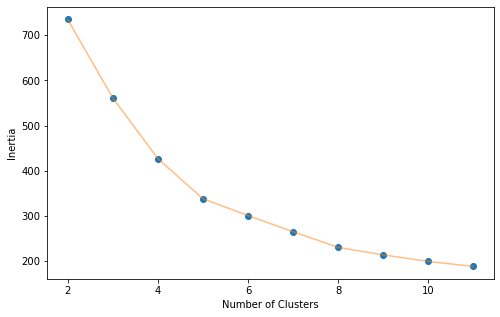

In [307]:
# elbow 탐색
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (8, 5))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], df.iloc[:,1:])

# k = 5로 결정

In [308]:
kmeans = KMeans(n_clusters = 8, random_state= 42)
km_cluster = kmeans.fit_predict(df.iloc[:, 1:])

df_clust = df.copy()
df_clust['km_cluster'] = km_cluster

In [309]:
# n_c = len(np.unique(df_clust.km_cluster)) 

# grid = gridspec.GridSpec(9, 2)
# plt.subplots_adjust(wspace = 0.2, hspace = 0.5)

# fig = plt.figure(figsize = (20, 8))
# for k in range(n_c):
#     temp = df_clust[df_clust.km_cluster == k]
#     plt.subplot(grid[2*k])
#     for i in range(len(temp)):
#         plt.plot(temp.iloc[i,1:8], linewidth=0.7)
#         plt.title(f'cluster{k}')
#         plt.xlabel('')
#         plt.xticks([])
#     plt.subplot(grid[2*k+1])
#     for i in range(len(temp)):
#         plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
#         plt.title(f'cluster{k}')
#         plt.xlabel('')
#         plt.xticks([])

In [310]:
df_clust

,건물번호,일0,일1,일2,일3,일4,일5,일6,시간0,시간1,...,시간15,시간16,시간17,시간18,시간19,시간20,시간21,시간22,시간23,km_cluster
0,1,0.354479,0.733410,0.167301,0.288357,0.757638,-0.149701,-2.151485,-0.925808,-1.007658,...,1.293447,1.213080,0.793967,0.236241,0.049727,-0.157488,-0.665691,-1.153928,-0.868341,7
1,2,-2.244049,0.364491,0.361030,0.396495,0.388246,0.615772,0.118016,-0.913227,-0.927414,...,1.299381,1.238458,1.149012,1.079436,0.659087,0.290677,-0.271254,-1.557083,-0.843624,4
2,3,-2.135505,0.187228,0.067846,0.341382,0.778650,0.820665,-0.060268,-0.879527,-0.977422,...,0.880242,1.045453,1.207463,1.741270,1.871845,1.552786,0.773324,-0.327529,-0.762230,4
3,4,1.185829,0.130308,-0.410098,-1.581926,-0.849921,0.862270,0.663539,-1.010475,-1.032012,...,1.192486,1.072934,0.690255,0.138835,-0.422132,-0.614243,-0.769305,-0.855113,-0.997512,1
4,5,-1.060515,-0.947378,-0.669090,-0.439377,0.791504,1.226050,1.098805,-0.976701,-0.975248,...,1.176149,1.105241,1.111577,0.310362,-0.101649,-0.207595,-0.805007,-1.130213,-1.164414,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,-0.180432,-0.170685,-1.681843,-0.420702,0.032655,1.187914,1.233093,-1.217143,-1.294231,...,1.077863,0.978579,0.994577,0.862967,0.649823,0.402540,0.268996,-0.536701,-0.894368,1
96,97,-1.255439,0.363278,-1.154648,-0.033780,0.570071,1.618895,-0.108377,-1.194812,-1.392483,...,1.120881,1.091899,1.096815,0.894985,0.804394,0.708429,0.296930,-0.334492,-0.851732,1
97,98,-0.362218,-0.090280,-1.479926,0.106548,1.370242,1.143718,-0.688085,-1.451166,-1.562983,...,0.967059,1.020801,1.082780,0.830753,0.590012,0.360724,-0.048873,-0.781169,-1.101976,1
98,99,0.085745,-0.556869,-0.875182,-1.174021,-0.122903,1.443764,1.199466,-1.151593,-1.318088,...,1.050229,1.189285,1.179431,0.929626,0.660029,0.595944,0.205280,-0.425432,-0.862162,1


In [311]:
# df_clust.to_csv('../submission/cluster.csv', index = False)

(array([29., 13.,  8.,  0.,  4.,  9.,  0., 11.,  4., 22.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

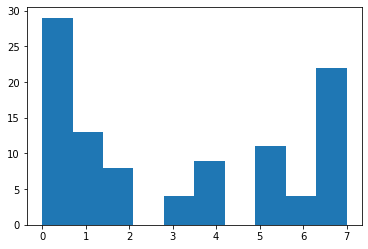

In [312]:
plt.hist(df_clust['km_cluster'])

In [313]:
clust = df_clust[['건물번호', 'km_cluster']]
train_df = pd.merge(train_df, clust)

In [314]:
train_df.columns

Index([      '건물번호',         '기온',         '풍속',         '습도',      '전력소비량',
               '요일',         '시간',     'sin_요일',     'cos_요일',     'sin_시간',
           'cos_시간',         '휴일',            6,            7,            8,
           '요일별_평균',     '시간별_평균',   '시간별_표준편차',        '열지수',     '불쾌지수_0',
           '불쾌지수_1',     '불쾌지수_2',     '불쾌지수_3',        'CDH', 'km_cluster'],
      dtype='object')

In [317]:
train_df = train_df[['건물번호', '전력소비량', '기온', '습도', '풍속', 'sin_요일', 'cos_요일',
       'sin_시간', 'cos_시간', '휴일', '열지수', '불쾌지수_0', '불쾌지수_1', '불쾌지수_2', 'CDH',
       '요일별_평균', '시간별_평균', '시간별_표준편차', 6, 7, 'km_cluster']]

train_dfs  = []
for i in range(1,101):
    train_dfs.append(train_df[train_df['건물번호'] == i])

train_dfs_1 = []
for i in range(8):
    train_dfs_1.append(train_df[train_df['km_cluster'] == i])

In [318]:
for i in range(100):
    train_dfs[i] = train_dfs[i].drop(columns = ['건물번호', 'km_cluster'])

for i in range(8):
    train_dfs_1[i] = train_dfs_1[i].drop(columns = ['건물번호', 'km_cluster'])

In [319]:
train_dfs_1[4]

,전력소비량,기온,습도,풍속,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,CDH,요일별_평균,시간별_평균,시간별_표준편차,6,7
2040,1170.36,18.6,42.0,0.9,0.866025,-0.5,0.000000e+00,1.000000,0,78.408916,1,0,0,18.6,1242.553846,1239.435529,106.142868,1,0
2041,1146.96,18.0,45.0,1.1,0.866025,-0.5,2.697968e-01,0.962917,0,79.147251,1,0,0,18.0,1238.510769,1232.637882,104.424922,1,0
2042,1115.28,17.7,45.0,1.5,0.866025,-0.5,5.195840e-01,0.854419,0,79.492837,1,0,0,17.7,1225.744615,1223.157176,101.616820,1,0
2043,1107.00,16.7,48.0,1.4,0.866025,-0.5,7.308360e-01,0.682553,0,80.948219,1,0,0,16.7,1206.221538,1199.210824,108.909416,1,0
2044,1069.92,18.4,43.0,2.8,0.866025,-0.5,8.878852e-01,0.460065,0,78.649811,1,0,0,18.4,1167.673846,1181.644941,131.298078,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110155,2543.40,22.1,79.0,2.9,0.866025,-0.5,-8.878852e-01,0.460065,0,72.372885,0,1,0,22.1,2807.418462,2689.968706,624.370325,0,0
110156,1776.96,21.9,80.0,2.9,0.866025,-0.5,-7.308360e-01,0.682553,0,71.813217,0,1,0,21.9,1991.658462,1946.655529,444.553699,0,0
110157,922.68,21.7,82.0,2.7,0.866025,-0.5,-5.195840e-01,0.854419,0,70.917469,0,1,0,21.7,960.507692,945.760235,148.911822,0,0
110158,956.88,21.7,81.0,2.1,0.866025,-0.5,-2.697968e-01,0.962917,0,71.235792,0,1,0,21.7,833.067692,824.088706,132.399541,0,0


In [320]:
train_input = [] 
train_target = []

for i in range(len(train_dfs)):
    train_input.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[1:]])) 
    train_target.append(copy.deepcopy(train_dfs[i][train_dfs[i].columns[0]]))

In [321]:
train_input_1 = [] 
train_target_1 = []

for i in range(len(train_dfs_1)):
    train_input_1.append(copy.deepcopy(train_dfs_1[i][train_dfs_1[i].columns[1:]])) 
    train_target_1.append(copy.deepcopy(train_dfs_1[i][train_dfs_1[i].columns[0]]))

In [322]:
test

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


In [323]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_date_time  16800 non-null  object 
 1   건물번호           16800 non-null  int64  
 2   일시             16800 non-null  object 
 3   기온(C)          16800 non-null  float64
 4   강수량(mm)        16800 non-null  float64
 5   풍속(m/s)        16800 non-null  float64
 6   습도(%)          16800 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 918.9+ KB


In [324]:
test_df = test.copy()

test_df = test_df.drop(columns =  ['num_date_time', '강수량(mm)'])
test_df = test_df.rename(columns = {'기온(C)':'기온', '풍속(m/s)':'풍속', '습도(%)':'습도'})

## 일시 columns
test_df['일시'] = pd.to_datetime(test_df['일시'])
test_df['월'] = test_df['일시'].dt.month
test_df['일'] = test_df['일시'].dt.day
test_df['요일'] = test_df['일시'].dt.weekday
test_df['시간'] = test_df['일시'].dt.hour
# test_df['날짜'] = test_df['일시'].dt.date

test_df['sin_요일'] = np.sin(2*np.pi*(test_df['요일'])/6)
test_df['cos_요일'] = np.cos(2*np.pi*(test_df['요일'])/6)
test_df['sin_시간'] = np.sin(2*np.pi*(test_df['시간'])/23)
test_df['cos_시간'] = np.cos(2*np.pi*(test_df['시간'])/23)
# test_df['sin_일'] = np.sin(2*np.pi*(test_df['일']-1)/30)
# test_df['cos_일'] = np.cos(2*np.pi*(test_df['일']-1)/30)
# test_df['일수'] = test_df['일시'].dt.dayofyear

test_df['휴일'] = test_df['요일'].isin([5,6]).astype(int)

# 파생변수 생성 - 열지수
test_df['기온(F)'] = (test_df['기온'] * 9/5) + 32
T = test_df['기온(F)']
RH = test_df['습도']
test_df['열지수'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
# test_df['열지수'] = pd.cut(test_df['열지수'], bins = [0, 80, 90, 103, 124, 200], labels = [0, 1, 2, 3, 4])

# 파생변수 생성 - 체감온도
# T = test_df['기온']
# W = test_df['풍속']
# test_df['체감온도'] = 13.12 + 0.6215*T - 11.37*(W)**0.16 + 0.3965*(W)**0.16*T

# 파생변수 생성 - 불쾌지수
T = 9/5*test_df['기온']
RH = test_df['습도']
test_df['불쾌지수'] = T - 0.55*(1-RH/100)*(T-26)+32
test_df['불쾌지수'] = pd.cut(test_df['불쾌지수'], bins = [0, 68, 75, 80, 200], labels = [0, 1, 2, 3])
discomfort = pd.get_dummies(test_df['불쾌지수'])
test_df = pd.concat([test_df, discomfort], axis = 1).rename(columns = {0:'불쾌지수_0', 1:'불쾌지수_1', 2:'불쾌지수_2', 3:'불쾌지수_3'}).drop(columns = ['불쾌지수'])

# 파생변수 생성 - CDH

cdhs = np.array([])
for num in range(1, 101):
    temp = test_df[test_df['건물번호'] == num]
    cdh = CDH(temp['기온'].values)
    cdhs = np.concatenate([cdhs, cdh])

test_df['CDH'] = cdhs

# test_df['log_풍속'] = np.log1p(test_df['풍속'])

# 전력소비량 넣어주기
test_df['요일별_평균'] = test_df.progress_apply(lambda x : weekday_mean.loc[(weekday_mean.건물번호 == x['건물번호']) & (weekday_mean.시간 == x['시간']) & (weekday_mean.요일 == x['요일']), '전력소비량'].values[0], axis = 1)
# test_df['요일별_표준편차'] = test_df.progress_apply(lambda x : weekday_std.loc[(weekday_std.건물번호 == x['건물번호']) & (weekday_std.시간 == x['시간']) & (weekday_std.요일 == x['요일']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_평균'] = test_df.progress_apply(lambda x : hour_mean.loc[(hour_mean.건물번호 == x['건물번호']) & (hour_mean.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)
test_df['시간별_표준편차'] = test_df.progress_apply(lambda x : hour_std.loc[(hour_std.건물번호 == x['건물번호']) & (hour_std.시간 == x['시간']) ,'전력소비량'].values[0], axis = 1)

# test_df['log_요일별_평균'] = np.log1p(test_df['요일별_평균'])
# test_df['log_요일별_표준편차'] = np.log1p(test_df['요일별_표준편차'])
# test_df['log_시간별_평균'] = np.log1p(test_df['시간별_평균'])
# test_df['log_시간별_표준편차'] = np.log1p(test_df['시간별_표준편차'])

test_df[6] = 0
test_df[7] = 0
test_df[6] = test_df[6].astype('uint8')
test_df[7] = test_df[7].astype('uint8')
cat_month = pd.get_dummies(test_df['월'])
test_df = pd.concat([test_df, cat_month], axis = 1).drop(columns = ['월'])

100%|██████████| 16800/16800 [00:15<00:00, 1119.50it/s]


In [325]:
test_df = pd.merge(test_df, clust)

In [326]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16800 entries, 0 to 16799
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   건물번호        16800 non-null  int64         
 1   일시          16800 non-null  datetime64[ns]
 2   기온          16800 non-null  float64       
 3   풍속          16800 non-null  float64       
 4   습도          16800 non-null  int64         
 5   일           16800 non-null  int64         
 6   요일          16800 non-null  int64         
 7   시간          16800 non-null  int64         
 8   sin_요일      16800 non-null  float64       
 9   cos_요일      16800 non-null  float64       
 10  sin_시간      16800 non-null  float64       
 11  cos_시간      16800 non-null  float64       
 12  휴일          16800 non-null  int32         
 13  기온(F)       16800 non-null  float64       
 14  열지수         16800 non-null  float64       
 15  불쾌지수_0      16800 non-null  uint8         
 16  불쾌지수_1      16800 non-

In [327]:
test_df = test_df[['건물번호', '기온', '습도', '풍속', 'sin_요일', 'cos_요일',
       'sin_시간', 'cos_시간', '휴일', '열지수', '불쾌지수_0', '불쾌지수_1', '불쾌지수_2', 'CDH',
       '요일별_평균', '시간별_평균', '시간별_표준편차', 6, 7, 'km_cluster']]

test_input  = []
for i in range(1,101):
    test_input.append(test_df[test_df['건물번호']==i])

for i in range(100):
    test_input[i] = test_input[i].drop(columns = ['건물번호', 'km_cluster'])


test_input_1  = []
for i in range(8):
    test_input_1.append(test_df[test_df['km_cluster']==i])

for i in range(8):
    test_input_1[i] = test_input_1[i].drop(columns = ['건물번호', 'km_cluster'])


In [328]:
# import matplotlib.gridspec as gridspec 

# grid = gridspec.GridSpec(12,2)
# fig = plt.figure(figsize = (20, 15))
# plt.subplots_adjust(wspace = 0.3, hspace = 0.2)

# for idx, feature in enumerate(test_df.columns):
#     ax = plt.subplot(grid[idx])
#     plt.hist(test_df[feature])
#     plt.title(f"{feature}")

In [329]:
display(train_input[0])
display(test_input[0])
display(train_input_1[0])
display(test_input_1[0])

,기온,습도,풍속,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,CDH,요일별_평균,시간별_평균,시간별_표준편차,6,7
0,18.6,42.0,0.9,0.866025,-0.5,0.000000e+00,1.000000,0,78.408916,1,0,0,18.6,1774.744615,1706.318118,446.882767,1,0
1,18.0,45.0,1.1,0.866025,-0.5,2.697968e-01,0.962917,0,79.147251,1,0,0,18.0,1687.347692,1622.620235,439.662704,1,0
2,17.7,45.0,1.5,0.866025,-0.5,5.195840e-01,0.854419,0,79.492837,1,0,0,17.7,1571.483077,1506.971294,412.071906,1,0
3,16.7,48.0,1.4,0.866025,-0.5,7.308360e-01,0.682553,0,80.948219,1,0,0,16.7,1522.153846,1437.365647,391.205981,1,0
4,18.4,43.0,2.8,0.866025,-0.5,8.878852e-01,0.460065,0,78.649811,1,0,0,18.4,1506.793846,1447.321412,381.099697,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,25.5,63.0,2.9,0.866025,-0.5,-8.878852e-01,0.460065,0,79.681361,0,1,0,25.5,2571.470769,2703.871059,377.509334,0,0
2036,25.0,66.0,2.6,0.866025,-0.5,-7.308360e-01,0.682553,0,78.797002,0,1,0,25.0,2391.027692,2491.979294,356.589629,0,0
2037,24.6,67.0,1.3,0.866025,-0.5,-5.195840e-01,0.854419,0,78.058634,0,1,0,24.6,1887.950769,1972.305882,216.680162,0,0
2038,24.1,70.0,2.1,0.866025,-0.5,-2.697968e-01,0.962917,0,77.031069,0,1,0,24.1,1412.861538,1473.049412,114.999557,0,0


,기온,습도,풍속,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,CDH,요일별_평균,시간별_평균,시간별_표준편차,6,7
0,23.5,72,2.2,1.224647e-16,-1.0,0.000000e+00,1.000000,0,75.835980,0,1,0,23.5,1627.800000,1706.318118,446.882767,0,0
1,23.0,72,0.9,1.224647e-16,-1.0,2.697968e-01,0.962917,0,75.097159,0,1,0,23.0,1550.080000,1622.620235,439.662704,0,0
2,22.7,75,1.5,1.224647e-16,-1.0,5.195840e-01,0.854419,0,74.149922,0,1,0,22.7,1431.120000,1506.971294,412.071906,0,0
3,22.1,78,1.3,1.224647e-16,-1.0,7.308360e-01,0.682553,0,72.636805,0,1,0,22.1,1372.200000,1437.365647,391.205981,0,0
4,21.8,77,1.0,1.224647e-16,-1.0,8.878852e-01,0.460065,0,72.533716,0,1,0,21.8,1381.720000,1447.321412,381.099697,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,23.5,75,2.0,8.660254e-01,-0.5,-8.878852e-01,0.460065,0,75.442391,0,1,0,23.5,2571.470769,2703.871059,377.509334,0,0
164,22.4,80,2.0,8.660254e-01,-0.5,-7.308360e-01,0.682553,0,72.571571,0,1,0,22.4,2391.027692,2491.979294,356.589629,0,0
165,21.7,81,1.6,8.660254e-01,-0.5,-5.195840e-01,0.854419,0,71.235792,0,1,0,21.7,1887.950769,1972.305882,216.680162,0,0
166,21.1,83,1.0,8.660254e-01,-0.5,-2.697968e-01,0.962917,0,69.774703,0,1,0,21.1,1412.861538,1473.049412,114.999557,0,0


,기온,습도,풍속,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,CDH,요일별_평균,시간별_평균,시간별_표준편차,6,7
12240,17.9,48.0,1.0,0.866025,-0.5,0.000000e+00,1.000000,0,79.287431,1,0,0,17.9,440.640000,436.581176,126.070453,1,0
12241,17.7,50.0,1.2,0.866025,-0.5,2.697968e-01,0.962917,0,79.475748,1,0,0,17.7,442.744615,435.297882,123.066606,1,0
12242,17.5,49.0,1.7,0.866025,-0.5,5.195840e-01,0.854419,0,79.775004,1,0,0,17.5,434.658462,432.032471,119.876241,1,0
12243,15.9,54.0,0.4,0.866025,-0.5,7.308360e-01,0.682553,0,82.121613,1,0,0,15.9,426.793846,422.343529,120.835148,1,0
12244,16.6,53.0,2.6,0.866025,-0.5,8.878852e-01,0.460065,0,80.928389,1,0,0,16.6,428.252308,423.776471,120.757547,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161155,25.9,63.0,2.3,0.866025,-0.5,-8.878852e-01,0.460065,0,80.461896,0,1,0,25.9,2777.981538,2661.981176,294.549484,0,0
161156,24.8,66.0,2.7,0.866025,-0.5,-7.308360e-01,0.682553,0,78.434346,0,1,0,24.8,2576.603077,2510.659765,247.082874,0,0
161157,23.9,70.0,1.9,0.866025,-0.5,-5.195840e-01,0.854419,0,76.694048,0,1,0,23.9,2470.855385,2399.361882,245.088596,0,0
161158,23.6,71.0,0.7,0.866025,-0.5,-2.697968e-01,0.962917,0,76.112270,0,1,0,23.6,2381.353846,2309.850353,225.994555,0,0


,기온,습도,풍속,sin_요일,cos_요일,sin_시간,cos_시간,휴일,열지수,불쾌지수_0,불쾌지수_1,불쾌지수_2,CDH,요일별_평균,시간별_평균,시간별_표준편차,6,7
1008,22.8,75,1.1,1.224647e-16,-1.0,0.000000e+00,1.000000,0,74.294669,0,1,0,22.8,441.340000,436.581176,126.070453,0,0
1009,22.6,75,1.0,1.224647e-16,-1.0,2.697968e-01,0.962917,0,74.009978,0,1,0,22.6,432.900000,435.297882,123.066606,0,0
1010,22.2,77,1.0,1.224647e-16,-1.0,5.195840e-01,0.854419,0,73.022628,0,1,0,22.2,430.980000,432.032471,119.876241,0,0
1011,21.4,83,1.0,1.224647e-16,-1.0,7.308360e-01,0.682553,0,70.158913,0,1,0,21.4,419.940000,422.343529,120.835148,0,0
1012,21.2,85,0.3,1.224647e-16,-1.0,8.878852e-01,0.460065,0,69.137516,0,1,0,21.2,419.940000,423.776471,120.757547,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13267,22.4,84,1.1,8.660254e-01,-0.5,-8.878852e-01,0.460065,0,71.505454,0,1,0,22.4,2777.981538,2661.981176,294.549484,0,0
13268,21.5,86,0.8,8.660254e-01,-0.5,-7.308360e-01,0.682553,0,69.216258,0,1,0,21.5,2576.603077,2510.659765,247.082874,0,0
13269,21.8,86,0.9,8.660254e-01,-0.5,-5.195840e-01,0.854419,0,69.738384,0,1,0,21.8,2470.855385,2399.361882,245.088596,0,0
13270,21.1,93,0.4,8.660254e-01,-0.5,-2.697968e-01,0.962917,0,65.505271,0,1,0,21.1,2381.353846,2309.850353,225.994555,0,0


In [333]:
submission = pd.read_csv('../dataset/sample_submission.csv')

In [334]:
xgboost_params = {
    'objective':'reg:linear',
    'eval_metric' : 'rmse',
    'n_estimators':1000,
    'seed':42,
    'min_child_weight':6,
    'eta':0.01,
    'gamma':0,
    'max_depth':7,
    'sub_sample':0.9,
    'colsample_bytree' : 0.8,
    'lambda':1,
    'alpha':1e-08,
    'scale_pos_weight':1,
}


for i in range(len(train_input)):
    print(i)
    X_train = train_input[i].iloc[:-168]
    y_train = train_target[i].iloc[:-168]
    X_valid = train_input[i].iloc[-168:]
    y_valid = train_target[i].iloc[-168:]
    model = XGBRegressor(**xgboost_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    v = (model.predict(test_input[i][train_input[i].columns]))
    
    submission['answer'].iloc[(i)*168:(i+1)*168] += v
    clear_output(True)

99
[21:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[21:02:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

[0]	validation_0-rmse:914.49992
[1]	validation_0-rmse:905.79402
[2]	validation_0-rmse:897.00329
[3]	validation_0-rmse:888.50164
[4]	validation_0-rmse:880.05410
[5]	validation_0-rmse:871.71847
[6]	validation_0-rmse:863.61384
[7]	validation_0-rmse:855.24551
[8]	validation_0-rmse:847.30567
[9]	validation_0-rmse:839.28988
[10]	validation_0-rmse:831.35932
[11]	validation_0-rmse:823.48652
[12]	validation_0-rmse:815.69446
[13]	validation_0-rmse:808.01579
[14]	validation_0-rmse:800.52438
[15]	validation_0-rmse:792.99438
[16]	validation_0-rmse:785.41888
[17]	validation

In [ ]:
xgboost_params = {
    'objective':'reg:linear',
    'eval_metric' : 'rmse',
    'n_estimators':10000,
    'seed':42,
    'min_child_weight':1,
    'eta':0.1,
    'gamma':0,
    'max_depth':6,
    'sub_sample':1,
    'colsample_bytree' : 1,
    'lambda':1,
    'alpha':0,
    'scale_pos_weight':1,
}


for i in range(len(train_input_1)):
    print(i)
    X_train = train_input_1[i].iloc[:-168]
    y_train = train_target_1[i].iloc[:-168]
    X_valid = train_input_1[i].iloc[-168:]
    y_valid = train_target_1[i].iloc[-168:]
    model = XGBRegressor(**xgboost_params)
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
    v = (np.exp(model.predict(test_input_1[i][train_input_1[i].columns]))-1)
    
    submission['answer'].iloc[test_input_1[i].index] += v
    clear_output(True)

7
[19:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[19:10:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "sub_sample" } are not used.

[0]	validation_0-rmse:6.22387
[1]	validation_0-rmse:5.60652
[2]	validation_0-rmse:5.04923
[3]	validation_0-rmse:4.54818
[4]	validation_0-rmse:4.09522
[5]	validation_0-rmse:3.68856
[6]	validation_0-rmse:3.31981
[7]	validation_0-rmse:2.98885
[8]	validation_0-rmse:2.69184
[9]	validation_0-rmse:2.42323
[10]	validation_0-rmse:2.18312
[11]	validation_0-rmse:1.96576
[12]	validation_0-rmse:1.77146
[13]	validation_0-rmse:1.59570
[14]	validation_0-rmse:1.43742
[15]	validation_0-rmse:1.29463
[16]	validation_0-rmse:1.16632
[17]	validation_0-rmse:1.05057
[18]	validation_0-r

In [335]:
submission

,num_date_time,answer
0,1_20220825 00,1967.122192
1,1_20220825 01,1745.697144
2,1_20220825 02,1623.802979
3,1_20220825 03,1526.265625
4,1_20220825 04,1514.253906
...,...,...
16795,100_20220831 19,906.260864
16796,100_20220831 20,790.348022
16797,100_20220831 21,687.885986
16798,100_20220831 22,561.401367


In [336]:
submission['answer'] = np.round(submission['answer'], 2)
submission

,num_date_time,answer
0,1_20220825 00,1967.12
1,1_20220825 01,1745.70
2,1_20220825 02,1623.80
3,1_20220825 03,1526.27
4,1_20220825 04,1514.25
...,...,...
16795,100_20220831 19,906.26
16796,100_20220831 20,790.35
16797,100_20220831 21,687.89
16798,100_20220831 22,561.40


In [337]:
submission.to_csv('../submission/answer21.csv', index = False)

In [376]:
best = pd.read_csv('../submission/answer15.csv')
update = pd.read_csv('../submission/answer21.csv')

In [350]:
display(best)
display(update)

,num_date_time,answer
0,1_20220825 00,1925.136642
1,1_20220825 01,1893.762909
2,1_20220825 02,1788.864182
3,1_20220825 03,1615.842499
4,1_20220825 04,1625.564178
...,...,...
16795,100_20220831 19,899.154694
16796,100_20220831 20,795.610718
16797,100_20220831 21,710.113541
16798,100_20220831 22,631.441547


,num_date_time,answer
0,1_20220825 00,1967.12
1,1_20220825 01,1745.70
2,1_20220825 02,1623.80
3,1_20220825 03,1526.27
4,1_20220825 04,1514.25
...,...,...
16795,100_20220831 19,906.26
16796,100_20220831 20,790.35
16797,100_20220831 21,687.89
16798,100_20220831 22,561.40


In [374]:
x = np.array(best['num_date_time'])
y = np.array(best['answer'])


x_ = np.array(update['num_date_time'])
y_ = np.array(update['answer'])

In [ ]:
plt.figure(figsize = (30, 15))
plt.plot(x, y)
plt.plot(x_, y_)

In [377]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/((np.abs(true) + np.abs(pred))/2)) * 100

In [378]:
SMAPE(y, y_)

5.413256172433275